In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input

In [2]:
@tf.function
def map_image(image, label):
    image = tf.cast(image, tf.float32)
    image = image/255.0
    
    return image, image

In [3]:
BATCH_SIZE = 64
BUFFER_SIZE = 1024

In [4]:
train_dataset = tfds.load('cifar10', as_supervised = True, split = 'train')
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tfds.load('cifar10', as_supervised = True, split = 'test')
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteS8KK5A/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteS8KK5A/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [5]:
def encoder(inputs):
  conv_1 = Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same")(inputs)
  max_pool_1 = MaxPooling2D(pool_size = (2,2))(conv_1)

  conv_2 = Conv2D(filters = 128, kernel_size = (3,3), activation = "relu", padding = "same")(max_pool_1)
  max_pool_2 = MaxPooling2D(pool_size = (2,2))(conv_2)

  return max_pool_2

In [9]:
def bottleneck(inputs):
  conv_3 = Conv2D(filters = 256, kernel_size = (3,3), activation = "relu", padding = "same")(inputs)

  encoder_visualization = Conv2D(filters = 1, kernel_size = (3,3), activation = "sigmoid", padding = "same")(conv_3)

  return conv_3, encoder_visualization

In [36]:
def decoder(inputs):
  conv_1 =  Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding = "same")(inputs)
  upsample_1 = UpSampling2D(size = (2,2))(conv_1)

  conv_2 = Conv2D(filters = 64, kernel_size = (3,3), activation = "relu", padding = "same")(upsample_1)
  upsample_2 = UpSampling2D(size = (2,2))(conv_2)

  conv_3 = Conv2D(filters = 3, kernel_size = (3,3), activation = "sigmoid", padding = "same")(upsample_2)


  return conv_3

In [37]:
def convolutional_autoencoder():
  inputs = Input(shape = (32,32,3))
  encoder_output = encoder(inputs)
  bottleneck_output, encoder_visualization = bottleneck(encoder_output)
  decoder_output = decoder(bottleneck_output)

  conv_model = tf.keras.Model(inputs = inputs, outputs = decoder_output)
  conv_encoder_model = tf.keras.Model(inputs = inputs, outputs = encoder_visualization)

  return conv_model, conv_encoder_model

In [103]:
def display_one_row(disp_images, offset, shape=(32, 32,3)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image)


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(32,32,3))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(32,32,3))

In [94]:
def get_loss():
  loss = tf.keras.losses.MeanSquaredError()
  return loss

In [95]:
def get_optimizer():
  optimizer = tf.keras.optimizers.Adam()
  return optimizer

In [96]:
optimizer = get_optimizer()
train_loss = get_loss()

In [97]:
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'

In [98]:
def train_one_step(model, optimizer, X, y, loss):

  with tf.GradientTape() as tape:
    y_pred = model(X)
    train_loss = loss(y_pred = y_pred, y_true = y)

  gradients = tape.gradient(train_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return train_loss

In [99]:
@tf.function
def train(model, optimizer, train_dataset, loss, device, epochs):
  step = 0
  Loss = 0.0

  for epoch in range(epochs):
    for X,y in train_dataset:
      step +=1
      with tf.device(device_name = device):
        Loss = train_one_step(model, optimizer, X, y, loss)
        tf.print('Step', step, 
               ': train loss', Loss)
        

In [100]:
EPOCHS = 5

In [101]:
model, convolutional_encoder_model = convolutional_autoencoder()

In [ ]:
train(model, optimizer, train_dataset, train_loss, device, epochs = EPOCHS)

1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 109ms/step


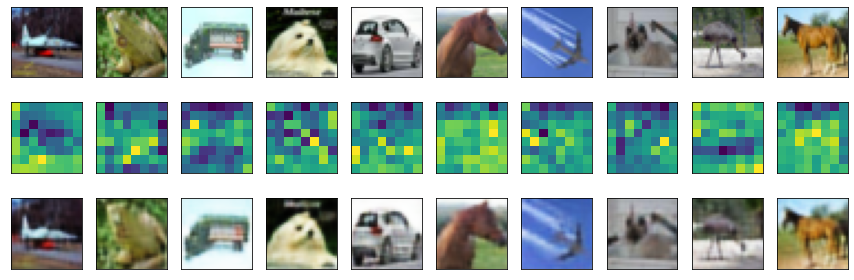

In [104]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 32, 32, 3))

# get the encoder ouput
encoded = convolutional_encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(8,8))